In [1]:
import rtde_control
import rtde_receive
import os
import numpy as np
import time
import threading
import queue
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from ur_teleop.devices.magiclaw.phone import PhoneSubscriber

In [ ]:
phone_subscriber = PhoneSubscriber(host="192.168.31.206", port=8000)

In [2]:
init_joint = np.array([-90.0, -60.0, -140.0, -70.0, -90.0, 0.0]) * np.pi / 180.0
rtde_c = rtde_control.RTDEControlInterface("192.168.31.10")
rtde_c.moveJ(init_joint.tolist(), 0.5, 1.2)

True

In [3]:
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.31.10")
initial_pose = np.array(rtde_r.getActualTCPPose())
initial_rot = R.from_rotvec(initial_pose[3:6])
print("Initial Pose:", initial_pose)

Initial Pose: [-0.13229468 -0.25645948  0.49656023  0.0005025   0.00153094  0.00260115]


In [41]:
def get_target_pose(initial_pose: np.ndarray, initial_rot: R, delta_trans: np.ndarray, delta_rot: R) -> np.ndarray:
    new_trans = initial_pose[:3] + delta_trans
    new_rot = delta_rot * initial_rot
    rotvec = new_rot.as_rotvec()
    
    return np.concatenate([new_trans, rotvec])

def get_delta_pose(initial_pose: np.ndarray, current_pose: np.ndarray) -> np.ndarray:
    initial_rot = R.from_rotvec(initial_pose[3:6])
    current_rot = R.from_rotvec(current_pose[3:6])
    delta_trans = current_pose[:3] - initial_pose[:3]
    delta_rot = current_rot * initial_rot.inv()
    
    return np.concatenate([delta_trans, delta_rot.as_rotvec()])

In [38]:
# Set target position (offset relative to initial position)
delta_pos = np.array([0.0, 0.2, 0.0])
delta_rot = R.from_euler('xyz', [0, 0, 0], degrees=True)

target_pose = get_target_pose(initial_pose, initial_rot, delta_pos, delta_rot)
speed = 0.2
acceleration = 2.0

Starting dual-thread control...
Data collection thread started
Robot control thread started
Target position: [-0.13229468 -0.05645948  0.49656023  0.0005025   0.00153094  0.00260115]
Robot reached target position
Returning to initial position...
Robot reached target position
Returning to initial position...
Data points: 200, Time: 4.01s, Position: [-0.132, -0.216, 0.497]
Data points: 200, Time: 4.01s, Position: [-0.132, -0.216, 0.497]
Robot returned to initial position
Robot control thread ended
Data collection thread ended

Task completed! Collected 224 data points

=== Motion Data Analysis ===
Total data points: 224
Collection time: 4.51 seconds
Average sampling rate: 49.7 Hz

Position change range (mm):
  X-axis: -132.3 → -132.3 (change: 0.0)
  Y-axis: -256.5 → -56.5 (change: 200.0)
  Z-axis: 496.5 → 496.7 (change: 0.2)

Velocity statistics:
  Maximum linear velocity: 101.0 mm/s
  Average linear velocity: 88.3 mm/s
  Maximum angular velocity: 0.008 rad/s
  Average angular velocity: 

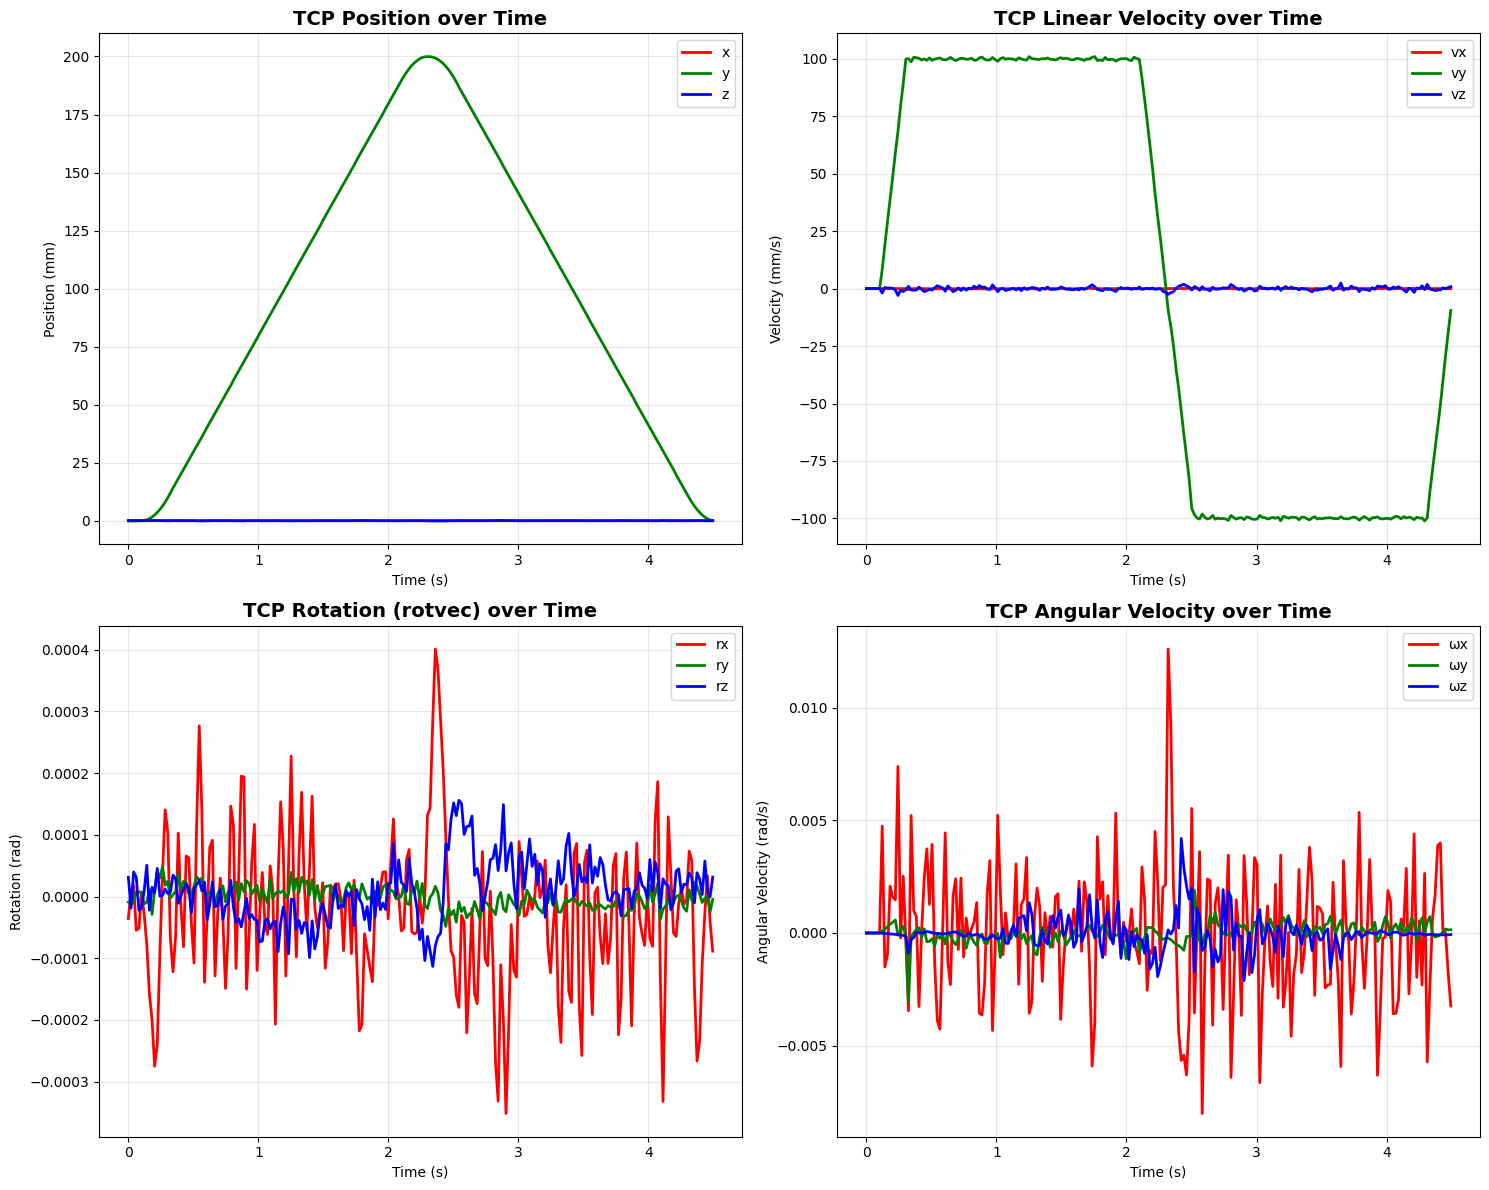

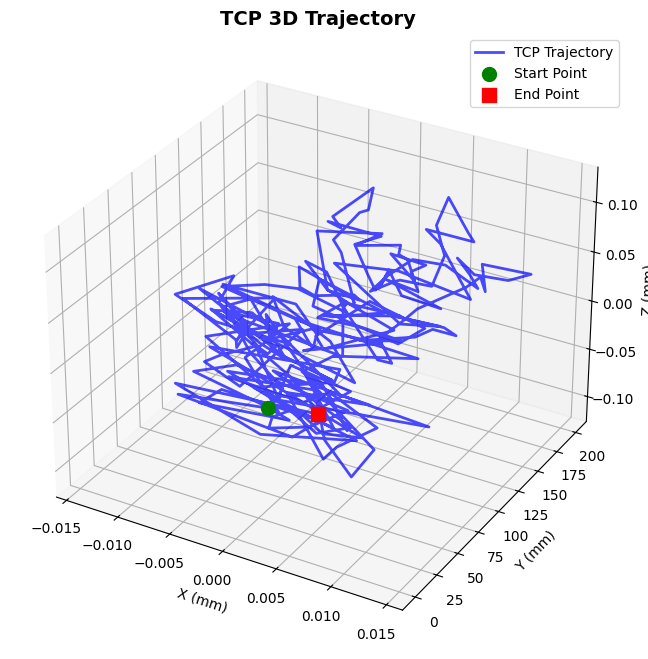

✅ Data saved to: data/phone_test/0_200_0_0_0_0_200_2000
📁 Contains files:
   📄 tcp_pose.txt - TCP pose data
   📄 tcp_speed.txt - TCP speed data
   📄 time.txt - timestamp data
   📄 motion_params.txt - motion parameters


In [42]:

# Data storage
pose_list = []
speed_list = []
time_list = []

# Control flag
data_collection_active = threading.Event()
data_collection_active.set()

# Thread 1: Data collection thread
def data_collection_thread():
    """Continuously read robot pose and speed data"""
    print("Data collection thread started")
    start_time = time.time()
    
    while data_collection_active.is_set():
        try:
            # Read current robot state
            current_pose = rtde_r.getActualTCPPose()
            current_speed = rtde_r.getActualTCPSpeed()
            current_time = time.time() - start_time
            
            # Store data
            pose_list.append(get_delta_pose(initial_pose, np.array(current_pose)).tolist())
            speed_list.append(current_speed)
            time_list.append(current_time)
            
            # Print status periodically
            if len(pose_list) % 200 == 0:
                print(f"Data points: {len(pose_list)}, Time: {current_time:.2f}s, "
                      f"Position: [{current_pose[0]:.3f}, {current_pose[1]:.3f}, {current_pose[2]:.3f}]")
            
            # Control sampling frequency (100Hz)
            time.sleep(0.02)
            
        except Exception as e:
            print(f"Data collection error: {e}")
            break
    
    print("Data collection thread ended")

# Thread 2: Robot control thread
def robot_control_thread():
    """Control robot movement"""
    print("Robot control thread started")
    print(f"Target position: {target_pose}")
    
    try:
        # Move to target position
        rtde_c.moveL(target_pose.tolist(), speed, acceleration)
        print("Robot reached target position")
        
        # Wait for a while to let data collection continue
        # time.sleep(1.0)
        
        # Return to initial position
        print("Returning to initial position...")
        rtde_c.moveL(initial_pose.tolist(), speed, acceleration)
        print("Robot returned to initial position")
        
    except Exception as e:
        print(f"Robot control error: {e}")
    finally:
        # Stop data collection
        data_collection_active.clear()
        print("Robot control thread ended")

# Clear previous data
pose_list.clear()
speed_list.clear()
time_list.clear()

# Create and start threads
print("Starting dual-thread control...")
data_thread = threading.Thread(target=data_collection_thread, daemon=True)
control_thread = threading.Thread(target=robot_control_thread, daemon=True)

# Start threads
data_thread.start()
time.sleep(0.1)  # Let data thread start first
control_thread.start()

# Wait for control thread to complete
try:
    control_thread.join()
    data_thread.join(timeout=2.0)  # Wait for data thread to end, max 2 seconds
except KeyboardInterrupt:
    print("\nUser interrupted")
    data_collection_active.clear()
    rtde_c.stopScript()

print(f"\nTask completed! Collected {len(pose_list)} data points")

if len(pose_list) > 0:
    data_dir = f"data/phone_test/{delta_pos[0]*1000:.0f}_{delta_pos[1]*1000:.0f}_{delta_pos[2]*1000:.0f}_{delta_rot.as_euler('xyz', degrees=True)[0]:.0f}_{delta_rot.as_euler('xyz', degrees=True)[1]:.0f}_{delta_rot.as_euler('xyz', degrees=True)[2]:.0f}_{speed*1000:.0f}_{acceleration*1000:.0f}"
    os.makedirs(data_dir, exist_ok=True)
    fig = plt.figure(figsize=(15, 12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # Display detailed statistics
    print(f"\n=== Motion Data Analysis ===")
    print(f"Total data points: {len(pose_list)}")
    print(f"Collection time: {time_array[-1]:.2f} seconds")
    print(f"Average sampling rate: {len(pose_list)/time_array[-1]:.1f} Hz")
    
    print(f"\nPosition change range (mm):")
    print(f"  X-axis: {pose_array[:, 0].min()*1000:.1f} → {pose_array[:, 0].max()*1000:.1f} (change: {(pose_array[:, 0].max()-pose_array[:, 0].min())*1000:.1f})")
    print(f"  Y-axis: {pose_array[:, 1].min()*1000:.1f} → {pose_array[:, 1].max()*1000:.1f} (change: {(pose_array[:, 1].max()-pose_array[:, 1].min())*1000:.1f})")
    print(f"  Z-axis: {pose_array[:, 2].min()*1000:.1f} → {pose_array[:, 2].max()*1000:.1f} (change: {(pose_array[:, 2].max()-pose_array[:, 2].min())*1000:.1f})")
    
    print(f"\nVelocity statistics:")
    linear_speeds = np.linalg.norm(speed_array[:, :3], axis=1) * 1000
    angular_speeds = np.linalg.norm(speed_array[:, 3:], axis=1)
    print(f"  Maximum linear velocity: {linear_speeds.max():.1f} mm/s")
    print(f"  Average linear velocity: {linear_speeds.mean():.1f} mm/s")
    print(f"  Maximum angular velocity: {angular_speeds.max():.3f} rad/s")
    print(f"  Average angular velocity: {angular_speeds.mean():.3f} rad/s")
    
    # Convert to numpy arrays
    pose_array = np.array(pose_list)
    speed_array = np.array(speed_list)
    time_array = np.array(time_list)
    
    # Plot TCP position over time (convert to mm)
    ax1.plot(time_array, pose_array[:, 0] * 1000, 'r-', label='x', linewidth=2)
    ax1.plot(time_array, pose_array[:, 1] * 1000, 'g-', label='y', linewidth=2)
    ax1.plot(time_array, pose_array[:, 2] * 1000, 'b-', label='z', linewidth=2)
    ax1.set_title("TCP Position over Time", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Position (mm)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot TCP linear velocity over time (convert to mm/s)
    ax2.plot(time_array, speed_array[:, 0] * 1000, 'r-', label='vx', linewidth=2)
    ax2.plot(time_array, speed_array[:, 1] * 1000, 'g-', label='vy', linewidth=2)
    ax2.plot(time_array, speed_array[:, 2] * 1000, 'b-', label='vz', linewidth=2)
    ax2.set_title("TCP Linear Velocity over Time", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Velocity (mm/s)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot TCP rotation over time
    ax3.plot(time_array, pose_array[:, 3], 'r-', label='rx', linewidth=2)
    ax3.plot(time_array, pose_array[:, 4], 'g-', label='ry', linewidth=2)
    ax3.plot(time_array, pose_array[:, 5], 'b-', label='rz', linewidth=2)
    ax3.set_title("TCP Rotation (rotvec) over Time", fontsize=14, fontweight='bold')
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Rotation (rad)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot TCP angular velocity over time
    ax4.plot(time_array, speed_array[:, 3], 'r-', label='ωx', linewidth=2)
    ax4.plot(time_array, speed_array[:, 4], 'g-', label='ωy', linewidth=2)
    ax4.plot(time_array, speed_array[:, 5], 'b-', label='ωz', linewidth=2)
    ax4.set_title("TCP Angular Velocity over Time", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("Angular Velocity (rad/s)")
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig(os.path.join(data_dir, f"trajectory.png"), dpi=300)
    
    # Plot 3D trajectory
    fig_3d = plt.figure(figsize=(10, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    
    # Plot trajectory line
    ax_3d.plot(pose_array[:, 0] * 1000, pose_array[:, 1] * 1000, pose_array[:, 2] * 1000, 
               'b-', linewidth=2, alpha=0.7, label='TCP Trajectory')
    
    # Mark start and end points
    ax_3d.scatter(pose_array[0, 0] * 1000, pose_array[0, 1] * 1000, pose_array[0, 2] * 1000,
                  c='green', s=100, marker='o', label='Start Point')
    ax_3d.scatter(pose_array[-1, 0] * 1000, pose_array[-1, 1] * 1000, pose_array[-1, 2] * 1000,
                  c='red', s=100, marker='s', label='End Point')
    
    ax_3d.set_xlabel('X (mm)')
    ax_3d.set_ylabel('Y (mm)')
    ax_3d.set_zlabel('Z (mm)')
    ax_3d.set_title('TCP 3D Trajectory', fontsize=14, fontweight='bold')
    ax_3d.legend()
    plt.show()
    
    # Convert to numpy arrays
    pose_array = np.array(pose_list)
    speed_array = np.array(speed_list) 
    time_array = np.array(time_list)
    
    # Save data files
    np.savetxt(f"{data_dir}/tcp_pose.txt", pose_array, 
               header="x(m) y(m) z(m) rx(rad) ry(rad) rz(rad)", 
               fmt="%.6f", delimiter='\t')
    
    np.savetxt(f"{data_dir}/tcp_speed.txt", speed_array,
               header="vx(m/s) vy(m/s) vz(m/s) wx(rad/s) wy(rad/s) wz(rad/s)",
               fmt="%.6f", delimiter='\t')
    
    np.savetxt(f"{data_dir}/time.txt", time_array,
               header="time(s)",
               fmt="%.6f")
    
    # Save motion parameters
    with open(f"{data_dir}/motion_params.txt", 'w') as f:
        f.write(f"Initial Pose: {initial_pose}\n")
        f.write(f"Target Pose: {target_pose}\n") 
        f.write(f"Delta Position: {delta_pos}\n")
        f.write(f"Speed: {speed}m/s\n")
        f.write(f"Acceleration: {acceleration}m/s2\n")
        f.write(f"Total Time: {time_array[-1]:.3f}s\n")
        f.write(f"Data Points: {len(pose_list)}\n")
        f.write(f"Sampling Rate: {len(pose_list)/time_array[-1]:.1f}Hz\n")
    
    print(f"✅ Data saved to: {data_dir}")
    print(f"📁 Contains files:")
    print(f"   📄 tcp_pose.txt - TCP pose data")
    print(f"   📄 tcp_speed.txt - TCP speed data") 
    print(f"   📄 time.txt - timestamp data")
    print(f"   📄 motion_params.txt - motion parameters")

else:
    print("No data to display, please run the dual-thread control program first")